In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\Fernando\\.conda\\envs\\pyml310\\lib\\site-packages\\pyspark'

In [2]:
#importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Create SparkSession
spark = SparkSession.builder.appName('covid_data').getOrCreate()

In [4]:
#crear objeto de datos a partir de un csv
data = spark.read.csv("D:/datos_nomivac_covid19.csv", header=True, inferSchema=True)

In [5]:
#listo las columnas existentes
data.printSchema()

root
 |-- sexo: string (nullable = true)
 |-- grupo_etario: string (nullable = true)
 |-- jurisdiccion_residencia: string (nullable = true)
 |-- jurisdiccion_residencia_id: integer (nullable = true)
 |-- depto_residencia: string (nullable = true)
 |-- depto_residencia_id: integer (nullable = true)
 |-- jurisdiccion_aplicacion: string (nullable = true)
 |-- jurisdiccion_aplicacion_id: integer (nullable = true)
 |-- depto_aplicacion: string (nullable = true)
 |-- depto_aplicacion_id: integer (nullable = true)
 |-- fecha_aplicacion: date (nullable = true)
 |-- vacuna: string (nullable = true)
 |-- cod_dosis_generica: integer (nullable = true)
 |-- nombre_dosis_generica: string (nullable = true)
 |-- condicion_aplicacion: string (nullable = true)
 |-- orden_dosis: integer (nullable = true)
 |-- lote_vacuna: string (nullable = true)
 |-- id_persona_dw: double (nullable = true)



In [6]:
#creo columna periodo_aplicacion
data = data.withColumn("fecha_aplicacion", to_date("fecha_aplicacion", "yyyy-MM-dd"))
data = data.withColumn("periodo_aplicacion", date_format("fecha_aplicacion", "yyyy-MM"))
#data.show()

In [7]:
#creo una vista temporal a partir de las columnas necesarias
data.createOrReplaceTempView("aplicaciones_de_vacunas")

df = spark.sql("""
SELECT sexo,
        grupo_etario,
        jurisdiccion_aplicacion,
        periodo_aplicacion
FROM aplicaciones_de_vacunas
""")
df.show()
df.count()

+----+------------+-----------------------+------------------+
|sexo|grupo_etario|jurisdiccion_aplicacion|periodo_aplicacion|
+----+------------+-----------------------+------------------+
|   M|       50-59|           Buenos Aires|           2022-05|
|   M|       50-59|           Buenos Aires|           2022-01|
|   M|       30-39|           Buenos Aires|           2022-06|
|   M|       30-39|           Buenos Aires|           2022-04|
|   M|       30-39|           Buenos Aires|           2021-12|
|   M|       18-29|           Buenos Aires|           2022-09|
|   F|       50-59|           Buenos Aires|           2022-01|
|   F|       50-59|           Buenos Aires|           2023-03|
|   M|       40-49|           Buenos Aires|           2022-03|
|   F|       50-59|           Buenos Aires|           2022-01|
|   F|         <12|           Buenos Aires|           2022-11|
|   M|         <12|               Santa Fe|           2022-01|
|   M|         <12|                Córdoba|           2

118917307

In [8]:
#revisar cantidad de valores nulos en cada columna
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+------------+-----------------------+------------------+
|sexo|grupo_etario|jurisdiccion_aplicacion|periodo_aplicacion|
+----+------------+-----------------------+------------------+
|   0|           0|                      0|                 0|
+----+------------+-----------------------+------------------+



In [9]:
#eliminar nulos si es necesario
df.na.drop(how="any", thresh=None, subset=None)
df.count()

118917307

In [10]:
#agrupo el df por periodo, jurisdiccion y sexo
df_agrupado = df.groupBy("periodo_aplicacion", "jurisdiccion_aplicacion", "sexo").count()
df_agrupado = df_agrupado.withColumnRenamed("count", "cantidad_aplicaciones")
#quito los casos con sexo sin identificar (S.I.)
df_agrupado = df_agrupado.filter((col("sexo") == "M") | (col("sexo") == "F"))
#ordeno el resultado segun su periodo de aplicacion
df_ordenado = df_agrupado.orderBy(col("periodo_aplicacion").desc())
df_ordenado.show()
df_ordenado.count()

+------------------+-----------------------+----+---------------------+
|periodo_aplicacion|jurisdiccion_aplicacion|sexo|cantidad_aplicaciones|
+------------------+-----------------------+----+---------------------+
|           2025-10|                   CABA|   F|                  143|
|           2025-10|                  Salta|   F|                   22|
|           2025-10|                  Jujuy|   F|                   11|
|           2025-10|                Formosa|   M|                    5|
|           2025-10|                   CABA|   M|                  119|
|           2025-10|              Río Negro|   M|                    1|
|           2025-10|                Tucumán|   F|                   41|
|           2025-10|               San Juan|   M|                    3|
|           2025-10|               Santa Fe|   M|                   19|
|           2025-10|                  Chaco|   F|                   20|
|           2025-10|                Tucumán|   M|               

2818

In [11]:
df_ordenado.describe().show()

+-------+------------------+-----------------------+----+---------------------+
|summary|periodo_aplicacion|jurisdiccion_aplicacion|sexo|cantidad_aplicaciones|
+-------+------------------+-----------------------+----+---------------------+
|  count|              2818|                   2818|2818|                 2818|
|   mean|              NULL|                   NULL|NULL|   42115.139460610364|
| stddev|              NULL|                   NULL|NULL|    161649.6256982231|
|    min|           2020-12|           Buenos Aires|   F|                    1|
|    max|           2025-10|                Tucumán|   M|              2396575|
+-------+------------------+-----------------------+----+---------------------+



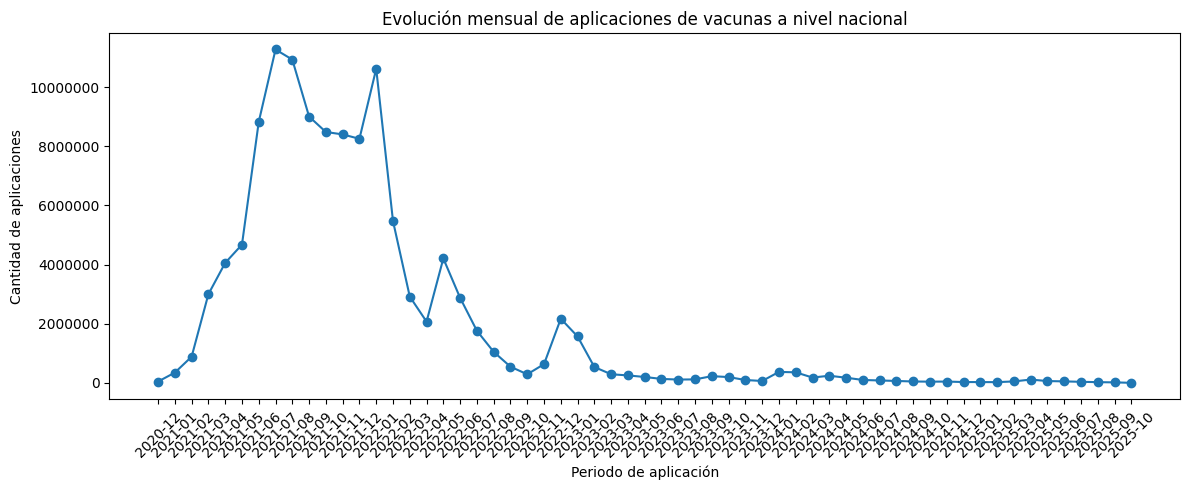

In [14]:
df_plot = df_ordenado.groupBy("periodo_aplicacion").agg({"cantidad_aplicaciones": "sum"}).toPandas().sort_values("periodo_aplicacion")

plt.figure(figsize=(12,5))
plt.plot(df_plot["periodo_aplicacion"], df_plot["sum(cantidad_aplicaciones)"], marker="o")
plt.title("Evolución mensual de aplicaciones de vacunas a nivel nacional")
plt.xlabel("Periodo de aplicación")
plt.ylabel("Cantidad de aplicaciones")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

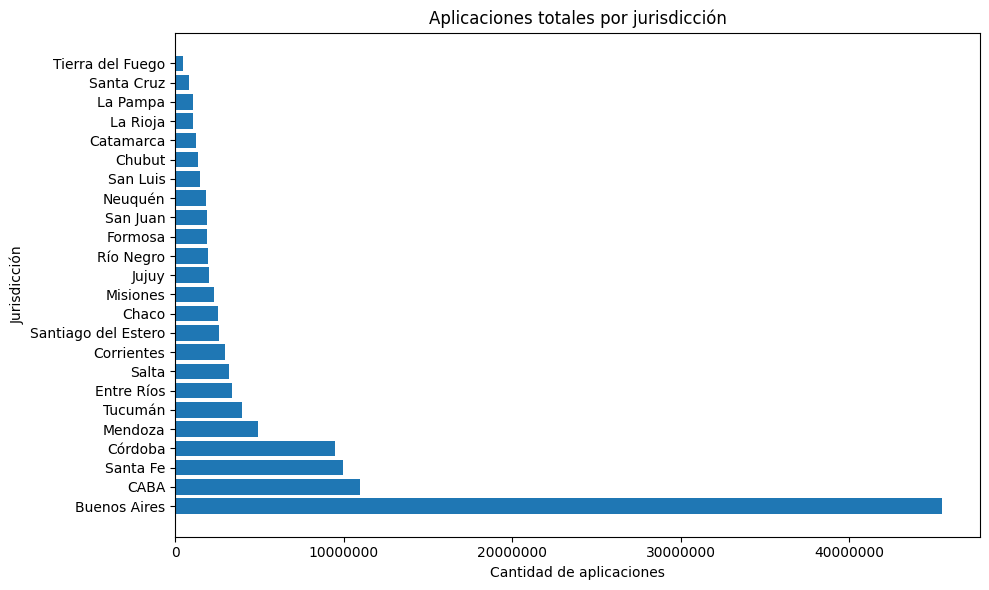

In [17]:
df_plot = df_ordenado.groupBy("jurisdiccion_aplicacion").agg({"cantidad_aplicaciones": "sum"}).toPandas()
df_plot = df_plot.sort_values("sum(cantidad_aplicaciones)", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(df_plot["jurisdiccion_aplicacion"], df_plot["sum(cantidad_aplicaciones)"])
plt.title("Aplicaciones totales por jurisdicción")
plt.xlabel("Cantidad de aplicaciones")
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()


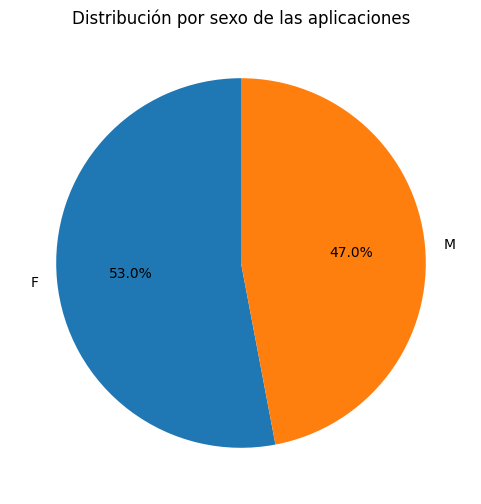

In [14]:
df_plot = df_ordenado.groupBy("sexo").agg({"cantidad_aplicaciones": "sum"}).toPandas()

plt.figure(figsize=(6,6))
plt.pie(df_plot["sum(cantidad_aplicaciones)"], labels=df_plot["sexo"], autopct="%1.1f%%", startangle=90)
plt.title("Distribución por sexo de las aplicaciones")
plt.show()


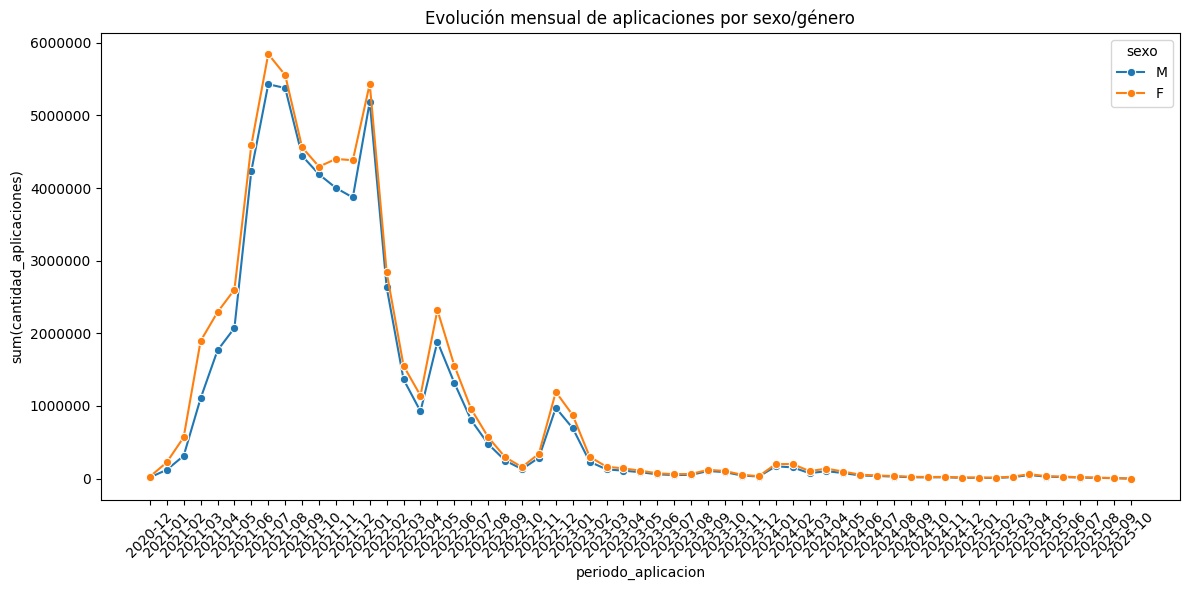

In [15]:
df_plot = df_ordenado.groupBy("periodo_aplicacion", "sexo").agg({"cantidad_aplicaciones": "sum"}).toPandas().sort_values("periodo_aplicacion")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_plot, x="periodo_aplicacion", y="sum(cantidad_aplicaciones)", hue="sexo", marker="o")
plt.title("Evolución mensual de aplicaciones por sexo/género")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


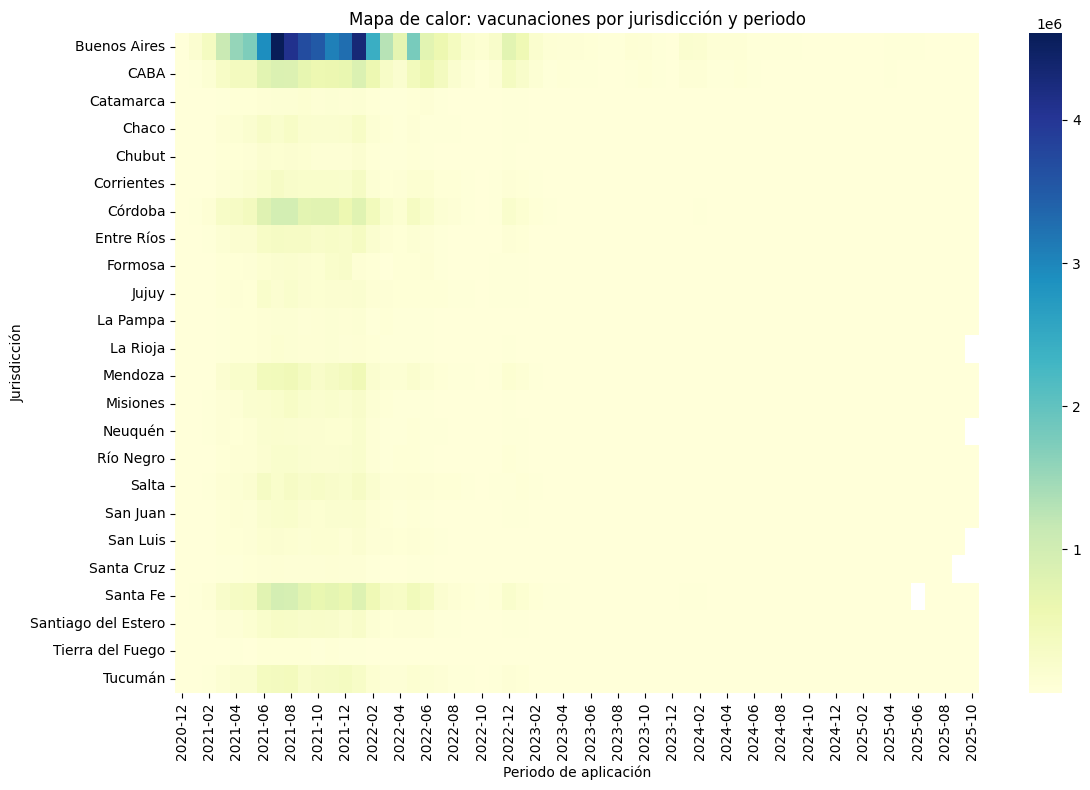

In [16]:
df_plot = df_ordenado.groupBy("jurisdiccion_aplicacion", "periodo_aplicacion") \
    .agg({"cantidad_aplicaciones": "sum"}).toPandas().sort_values("periodo_aplicacion")

pivot_df = df_plot.pivot(
    index="jurisdiccion_aplicacion",
    columns="periodo_aplicacion",
    values="sum(cantidad_aplicaciones)"
)

plt.figure(figsize=(12,8))
sns.heatmap(pivot_df, cmap="YlGnBu")
plt.title("Mapa de calor: vacunaciones por jurisdicción y periodo")
plt.xlabel("Periodo de aplicación")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()

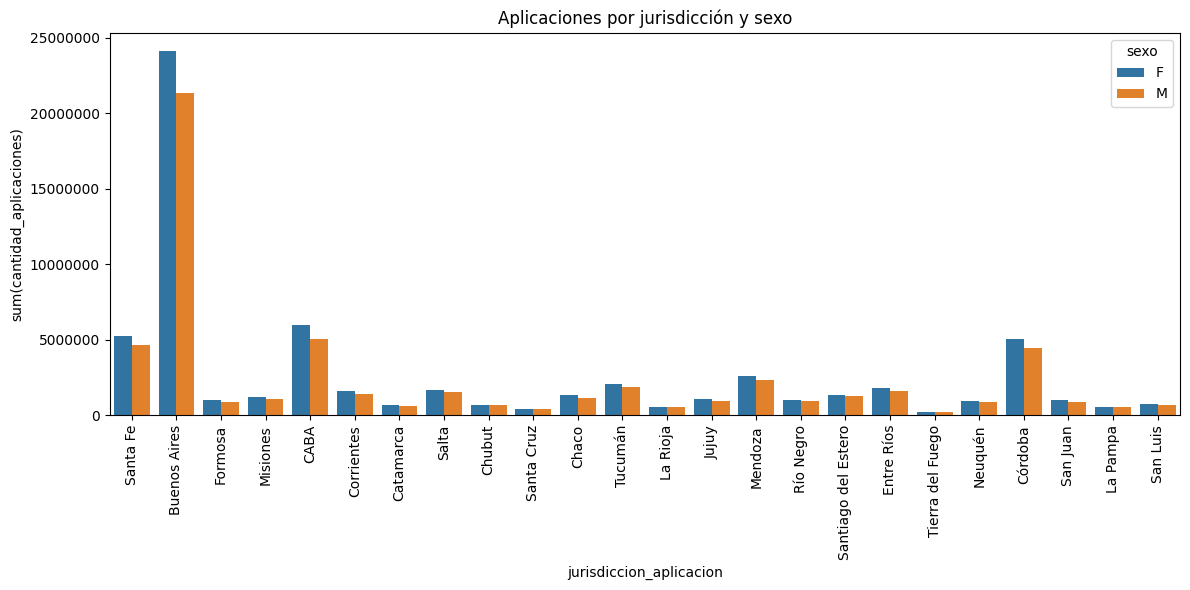

In [18]:
df_plot = df_ordenado.groupBy("jurisdiccion_aplicacion", "sexo").agg({"cantidad_aplicaciones": "sum"}).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x="jurisdiccion_aplicacion", y="sum(cantidad_aplicaciones)", hue="sexo")
plt.title("Aplicaciones por jurisdicción y sexo")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
# Finalizar la sesión de Spark
spark.stop()